# This file computes diagonalisation & pre-computes results for use later

## Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
from numpy import save, savez, savez_compressed
import ast

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import *

from tqdm import tqdm
from numba import jit

import scipy.constants
from scipy.sparse import csr_matrix, csgraph

In [2]:
import matplotlib.pyplot as plt
# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## Defining parameters

In [3]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133  
N_MAX=2

CHAR_MU = (1/(np.abs(MOLECULE["Mu1"])*MOLECULE["I1"]+np.abs(MOLECULE["Mu2"])*MOLECULE["I2"]))
CHAR_E = (1/np.abs(MOLECULE["C4"]*MOLECULE["I1"]*MOLECULE["I2"]*0.1))
CHAR_B = CHAR_E/CHAR_MU

CHAR_LENGTHS = 10
B_MAX = CHAR_LENGTHS / CHAR_B


print(B_MAX*1e4,"G")

GAUSS = 1e-4 # T
B = np.linspace(0.0000001,CHAR_LENGTHS/CHAR_B,200)# * GAUSS

B_STEPS = len(B)
B_MIN = B[0]
B_MAX= B[-1]

H_BAR = scipy.constants.hbar

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*MOLECULE["I1"])
I2_D = round(2*MOLECULE["I2"])

PER_MN = (I1_D+1)*(I2_D+1)
N_STATES = PER_MN * (N_MAX+1)**2
F_D_MAX = 2*N_MAX + I1_D + I2_D

24.66837408474519 G


# Generate canonical label & sparse edge ordering

In [4]:
UNCOUPLED_LABELS_D = []

for n in range(0, N_MAX + 1):
    for mn in range(n,-(n+1),-1):
        for mi1d in range(I1_D,-I1_D-1,-2):
            for mi2d in range(I2_D,-I2_D-1,-2):
                UNCOUPLED_LABELS_D.append((n,mn,mi1d,mi2d))

UNCOUPLED_LABELS_D = (np.rint(UNCOUPLED_LABELS_D)).astype("int")

In [5]:
generated_labels = np.zeros((N_STATES,3),dtype=int)
label_degeneracy_cache = np.zeros((N_MAX+1,F_D_MAX+1),dtype=int)
state_jump_list = np.zeros((N_MAX+1,F_D_MAX+1),dtype=int)

c=0
for N in range(0,N_MAX+1):
    F_D = 2*N + I1_D + I2_D
    for MF_D in range(-F_D,F_D+1,2):
        # Want number of ways of having
        # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
        d=0
        state_jump_list[N,(MF_D+F_D_MAX)//2]=c
        for MN in range(-N,N+1):
            for M_I1_D in range(-I1_D,I1_D+1,2):
                for M_I2_D in range(-I2_D,I2_D+1,2):
                    if 2*MN+M_I1_D+M_I2_D == MF_D:
                        generated_labels[c] = (N,MF_D,d)
                        d+=1
                        c+=1
        label_degeneracy_cache[N,(MF_D+F_D_MAX)//2]=d
        

def label_degeneracy(N,MF_D):
    return label_degeneracy_cache[N,(MF_D+F_D_MAX)//2]


def label_d_to_node_index(N,MF_D,d):
    return state_jump_list[N,(MF_D+F_D_MAX)//2]+d

In [6]:
generated_edge_labels = []
generated_edge_indices = []
edge_jump_list = []
for from_index, (N,MF_D,d_from) in enumerate(generated_labels):
    sub_jump_list = []
    sub_jump_list.append(len(generated_edge_labels))
    for dN in [1,-1]:
        for dMF_D in [0,-2*dN,2*dN]:
            if N>=N_MAX and dN==1:
                sub_jump_list.append(len(generated_edge_labels))
                continue # can't go higher
            if N<=0 and dN==-1:
                sub_jump_list.append(len(generated_edge_labels))
                continue # can't go lower
            if dN == -1:
                down_F_D =  2*(N-1) + I1_D + I2_D
                if MF_D+dMF_D > down_F_D or  MF_D+dMF_D < -down_F_D:
                    sub_jump_list.append(len(generated_edge_labels))
                    continue # lower state doesn't exist
            
            d_to = label_degeneracy(N+dN,MF_D+dMF_D)
            these_labels = []
            these_indices = []
            for k in range(d_to):
                these_labels.append((N,MF_D,d_from,N+dN,MF_D+dMF_D,k))
                these_indices.append((from_index,label_d_to_node_index(N+dN,MF_D+dMF_D,k)))
            generated_edge_labels.extend(these_labels)
            generated_edge_indices.extend(these_indices)
            sub_jump_list.append(len(generated_edge_labels))
            
    edge_jump_list.append(sub_jump_list)
    
N_TRANSITIONS = len(generated_edge_labels)

generated_edge_labels = np.array(generated_edge_labels,dtype=int)
generated_edge_indices = np.array(generated_edge_indices,dtype=int)
edge_jump_list = np.array(edge_jump_list,dtype=int)

def label_d_to_edge_indices(N,MF_D,d): # Returns the start indices of P=0,P=1,P=2, and the next edge
    return edge_jump_list[label_d_to_node_index(N,MF_D,d)]

## Diagonalise & Calculate 

In [7]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, MOLECULE, zeeman=True, Edc=False, ac=False)

H = (
    +H0[..., None]
    +Hz[..., None]*B
    ).transpose(2,0,1)

In [8]:
ENERGIES_UNSORTED, STATES_UNSORTED = eigh(H)

In [9]:
ENERGIES_HALF_SORTED, STATES_HALF_SORTED = calculate.sort_smooth(ENERGIES_UNSORTED,STATES_UNSORTED)

In [10]:
ENERGIES_before, STATES_before, labels_d = calculate.sort_by_state(ENERGIES_HALF_SORTED, STATES_HALF_SORTED, N_MAX, MOLECULE)

In [11]:
labels_d[:,1] *= 2 # Double MF to guarantee int
LABELS_D=(np.rint(labels_d)).astype("int")

In [12]:
canonical_to_energy_map = []
for N,MF_D,k in generated_labels:
    canonical_to_energy_map.append(np.where((LABELS_D[:, 0] == N) & (LABELS_D[:, 1] == MF_D) & (LABELS_D[:, 2] == k))[0][0])
canonical_to_energy_map = np.array(canonical_to_energy_map)

In [13]:
ENERGIES = ENERGIES_before[:,canonical_to_energy_map].T
STATES = STATES_before[:,:,canonical_to_energy_map] #[b,uncoupled,coupled]

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, '$E\\,\\,(c_4 i_1 i_2)$')

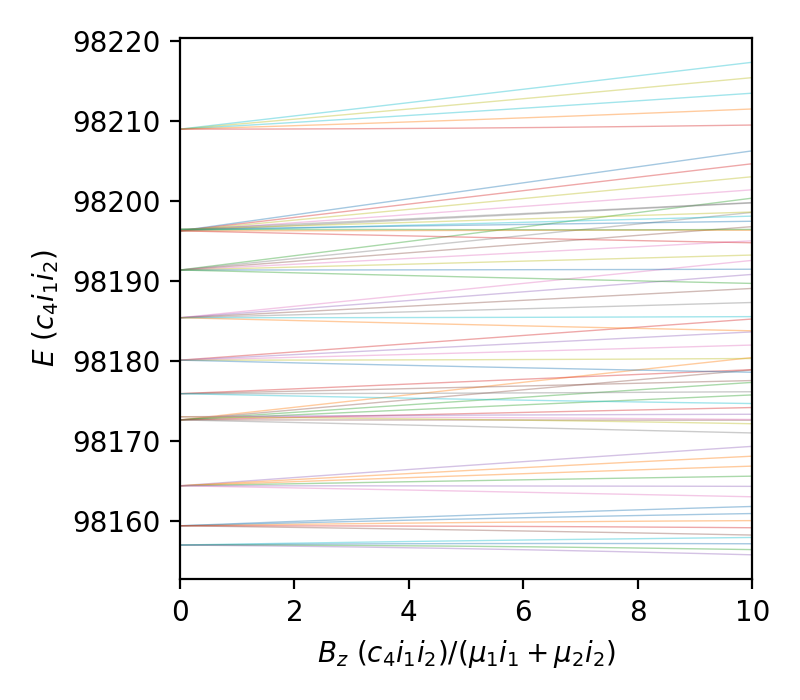

In [14]:
fig,ax = plt.subplots()
ax.plot(B*CHAR_B,(ENERGIES[PER_MN:3*PER_MN,:].T)*CHAR_E,lw=0.5,alpha=0.4)
ax.set_xlim(0,CHAR_LENGTHS)
# ax.set_ylim(-10,10)
ax.set_xlabel("$B_z\,\,(c_4 i_1 i_2)/(\mu_1 i_1+\mu_2 i_2)$")
ax.set_ylabel("$E\,\,(c_4 i_1 i_2)$")

In [15]:
MAGNETIC_MOMENTS = np.einsum('bji,jk,bki->ib', STATES.conj(), -Hz, STATES, optimize='optimal')

Text(0.5, 1.0, '$\\mu_{N=0,1,2}$')

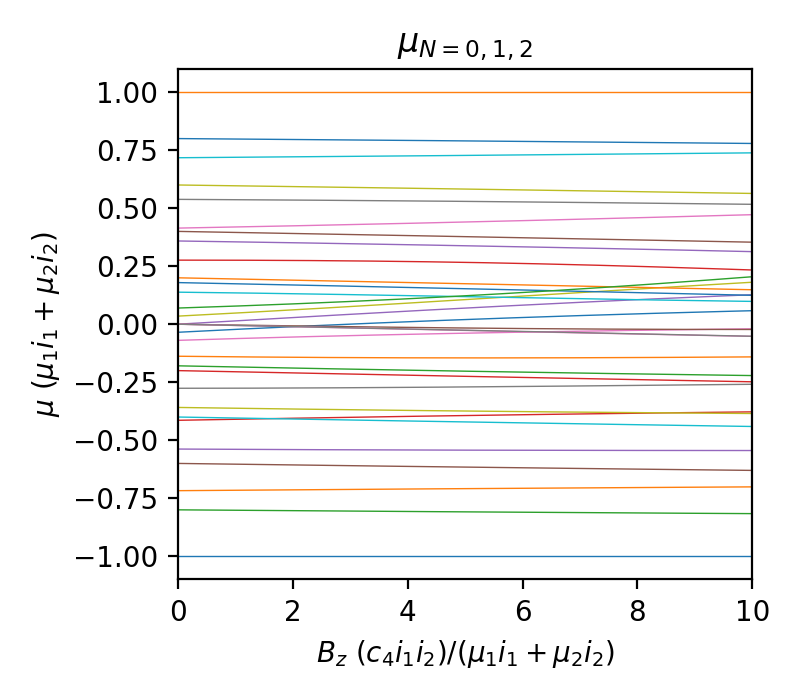

In [16]:
fig,ax = plt.subplots()
ax.plot(B*CHAR_B,(MAGNETIC_MOMENTS[0:PER_MN,:].T)*CHAR_MU,lw=0.5)
ax.set_xlim(0,CHAR_LENGTHS)
ax.set_ylim(-1.1,1.1)
ax.set_xlabel("$B_z\,\,(c_4 i_1 i_2)/(\mu_1 i_1+\mu_2 i_2)$")
ax.set_ylabel("$\mu \,\,(\mu_1 i_1+\mu_2 i_2)$")
ax.set_title("$\mu_{N=0,1,2}$")